A.S. Lundervold, v.13.03.24

# Introduction

> This notebook demonstrates the use of the fastai library for time series forecasting using the Rossman Store Sales dataset. 
The goal is to predict future sales based on historical data.

The Rossman Store Sales dataset provides historical sales data for 1,115 Rossman stores. The data set is from a Kaggle competition and the goal is to predict the sales of a store. 

The data set is split into three files: `train`, `test`, and `store`. 

* `train.csv` contains historical sales data from 01.01.2013 until 31.07.2015, which is used to train our model.
* `test.csv` contains six week's worth of data, from 01.08.2015 until 17.09.2015&ndash;without sales information&ndash;which we will use to predict sales as our model's test set.
* `store.csv` provides additional information about each store.



See the [Kaggle competition page](https://www.kaggle.com/c/rossmann-store-sales) for more information.


> The notebook is partly based on https://github.com/fastai/fastai/blob/master/dev_nbs/course/lesson6-rossmann.ipynb, and you should consult this for additional details.

# Setup

In [1]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Check if we are running on Kaggle
import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [3]:
from fastai.tabular.all import *

In [4]:
if kaggle: 
    DATA = Path('../input/fastai-v3-lesson-6-rossmandataset/')
elif not kaggle: 
    NB_DIR = Path.cwd()
    DATA = Path.home() / 'data' / 'rossmann-store-sales'
    DATA.mkdir(exist_ok=True, parents=True)

# Loading the data

Here is a snapshot of the original data from the competition: 

<img src="https://raw.githubusercontent.com/HVL-ML/DAT255/main/nbs/assets/rossman_orig_data.png">

In this notebook, we will use pre-cleaned data for brevity and educational purposes. However, in practice, data cleaning is of course a crucial step that can significantly impact the performance of your models, and you should take a look at https://github.com/fastai/fastai/blob/master/dev_nbs/course/rossman_data_clean.ipynb for details on how the data was prepared.

Downloading prepared data:

In [5]:
import subprocess

def download_kaggle_kernel_output(kernel_name, output_path):
    """
    Download the output of a Kaggle kernel using the Kaggle API.

    Parameters:
    kernel_name (str): The name of the Kaggle kernel.
    output_path (str): The path where the output should be saved.

    Returns:
    None
    """
    output_path = Path(output_path)

    # Check if the Kaggle API is installed
    if not Path('~/.kaggle').expanduser().exists():
        print("The Kaggle API is not installed. Please install it and try again.")
        return

    # Check if the output path exists
    if not output_path.exists():
        print(f"The output path '{output_path}' does not exist. Please check the path and try again.")
        return

    # Download the kernel output if not already downloaded
    try:
        if not (output_path / 'df').exists():
            print(f"Downloading the output of the kernel '{kernel_name}' to '{output_path}'...")
            subprocess.check_output(['kaggle', 'kernels', 'output', kernel_name, '-p', str(output_path)])
        else:
            print(f"The output of the kernel '{kernel_name}' has already been downloaded to '{output_path}'.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download the output of the kernel '{kernel_name}'. The error message was:\n{e.output}")

In [6]:
download_kaggle_kernel_output('init27/fastai-v3-rossman-data-clean', DATA)

The output of the kernel 'init27/fastai-v3-rossman-data-clean' has already been downloaded to 'C:\Users\Alexander\data\rossmann-store-sales'.


In [7]:
train_df = pd.read_pickle(DATA/'train_clean')
test_df = pd.read_pickle(DATA/'test_clean')

In [8]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [9]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0.0,0.0,0.0,0.0,0.0
Promo_bw,5.0,5.0,5.0,5.0,5.0
SchoolHoliday_fw,7.0,1.0,5.0,1.0,1.0
StateHoliday_fw,0.0,0.0,0.0,0.0,0.0


# Inspecting and preparing the data

In this section, we'll tidy up our dataset that was produced by the [fastai's Rossman data cleaning notebook](https://github.com/fastai/fastai/blob/master/dev_nbs/course/rossman_data_clean.ipynb). Here's what we're going to do:

1. **Remove unnecessary columns:** During preprocessing, new columns like `Year`, `Month`, `Week`, and `Day` were added, which means we no longer need the original `Date` column when training our model. However, we'll temporarily keep it to divide our dataset into training and validation sets.<br><br>
2. **Eliminate redundant features:** The `file` column doesn't provide relevant information for our analysis, so we'll remove it. The names of the states are repeated in `State` and in `StateName`, so we'll remove `State`. Additionally, any column names ending with `_DE` are duplicates created during data merging, so we'll drop these as well.

In [10]:
drop_cols = ["file", "Elapsed", "State"] + [feat for feat in train_df.columns if '_DE' in feat]

In [11]:
drop_cols

['file',
 'Elapsed',
 'State',
 'file_DE',
 'week_DE',
 'trend_DE',
 'Date_DE',
 'State_DE',
 'Month_DE',
 'Day_DE',
 'Dayofweek_DE',
 'Dayofyear_DE',
 'Is_month_end_DE',
 'Is_month_start_DE',
 'Is_quarter_end_DE',
 'Is_quarter_start_DE',
 'Is_year_end_DE',
 'Is_year_start_DE',
 'Elapsed_DE']

In [12]:
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

## Exploratory data analysis

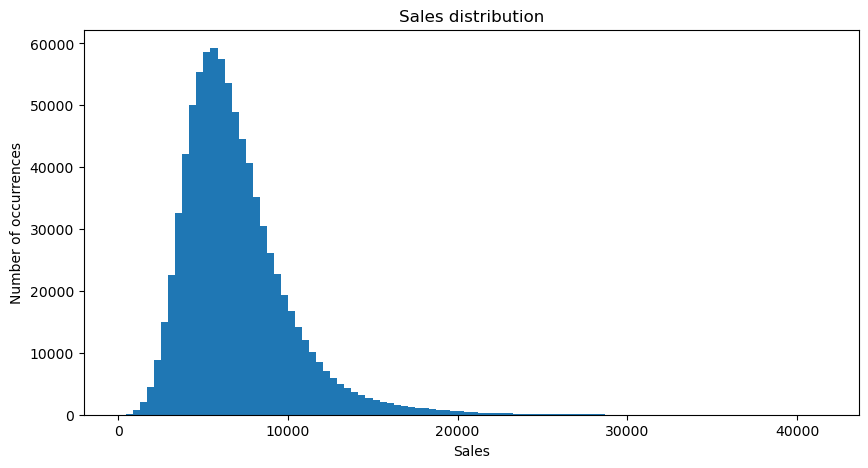

In [13]:
# Plot the distribution of sales
plt.figure(figsize=(10, 5))
plt.hist(train_df['Sales'], bins=100)
plt.title('Sales distribution')
plt.xlabel('Sales')
plt.ylabel('Number of occurrences')
plt.show()

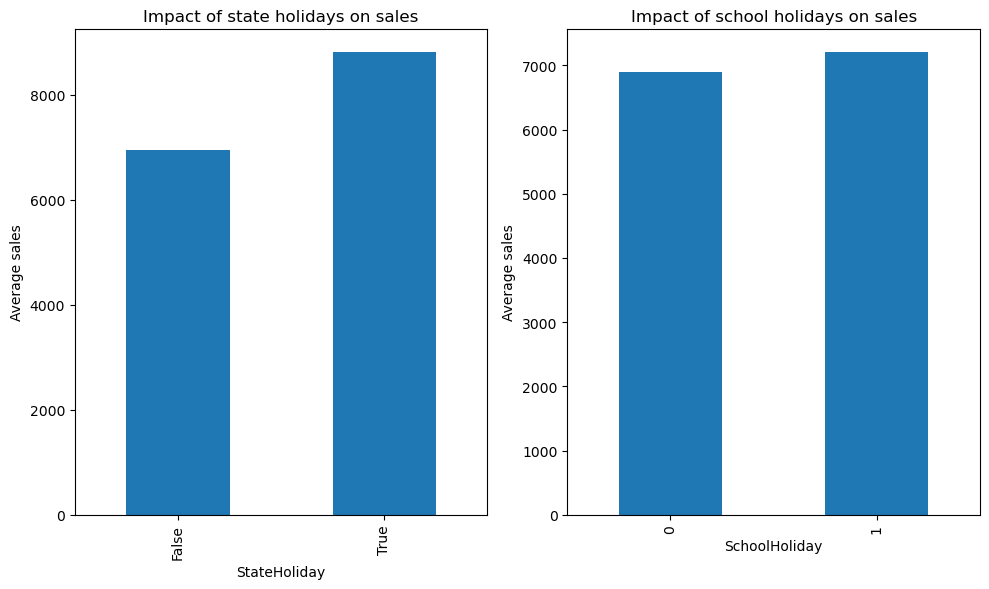

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# 'StateHoliday'
train_df.groupby('StateHoliday')['Sales'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Impact of state holidays on sales')
axs[0].set_xlabel('StateHoliday')
axs[0].set_ylabel('Average sales')

# 'SchoolHoliday'
train_df.groupby('SchoolHoliday')['Sales'].mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Impact of school holidays on sales')
axs[1].set_xlabel('SchoolHoliday')
axs[1].set_ylabel('Average sales')

plt.tight_layout()
plt.show()

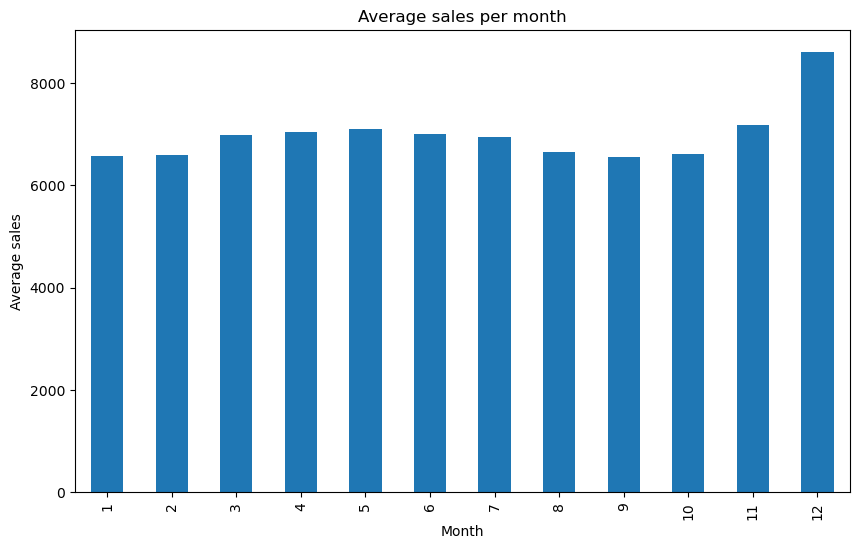

In [15]:
# Seasonality in sales
train_df.groupby('Month')['Sales'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average sales per month')
plt.xlabel('Month')
plt.ylabel('Average sales')
plt.show()

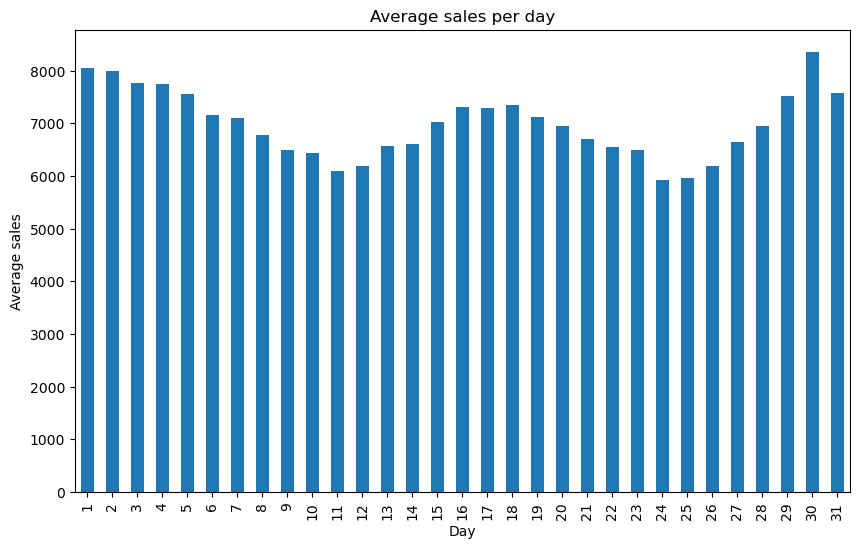

In [16]:
# Impact of day of the week on sales
train_df.groupby('Day')['Sales'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average sales per day')
plt.xlabel('Day')
plt.ylabel('Average sales')
plt.show()

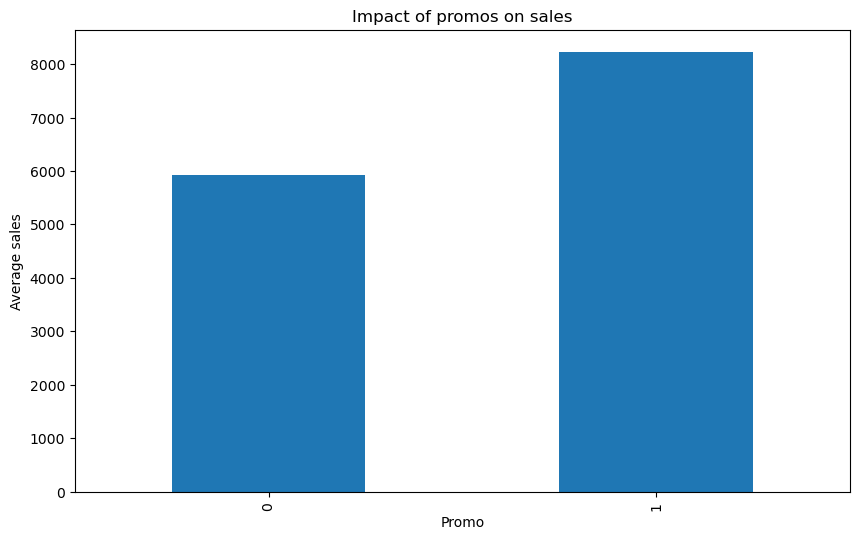

In [17]:
# Impact of Promos on sales
train_df.groupby('Promo')['Sales'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Impact of promos on sales')
plt.xlabel('Promo')
plt.ylabel('Average sales')
plt.show()


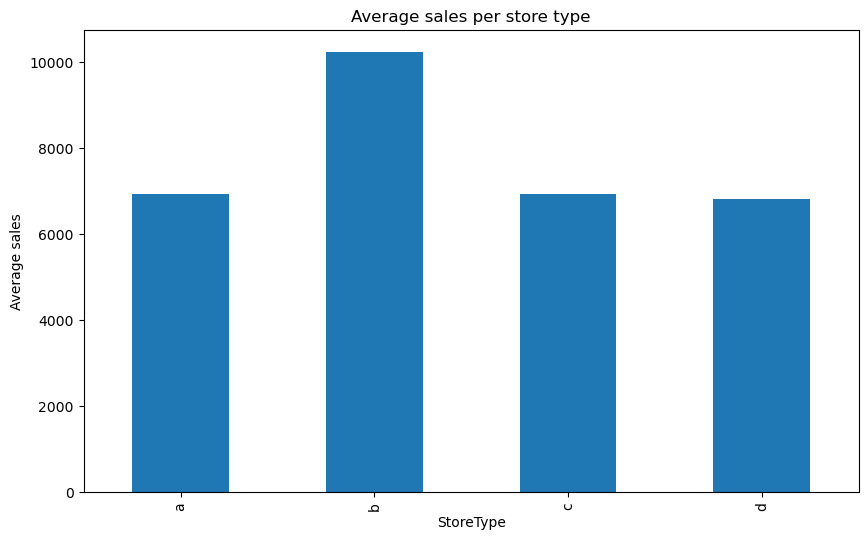

In [18]:
# Store type and sales
train_df.groupby('StoreType')['Sales'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average sales per store type')
plt.xlabel('StoreType')
plt.ylabel('Average sales')
plt.show()

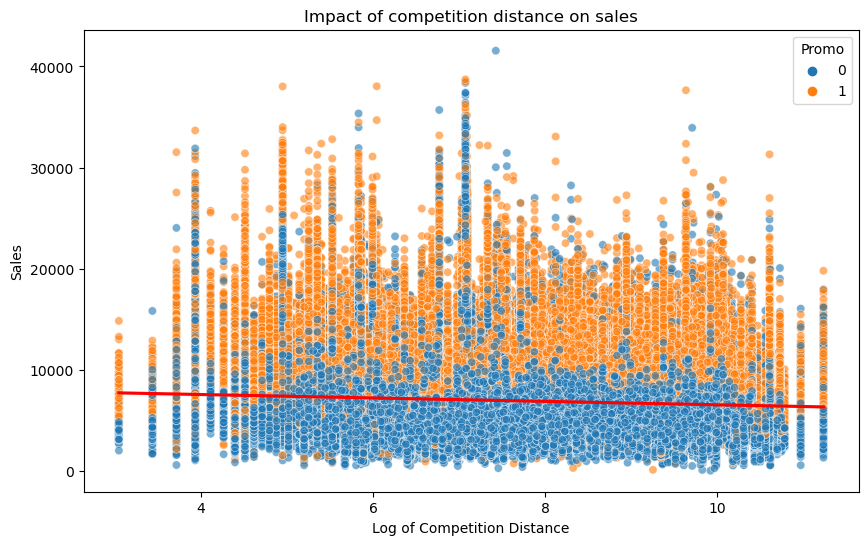

In [19]:
# Impact of competition distance on sales
import seaborn as sns

plt.figure(figsize=(10, 6))

# Log transform the 'CompetitionDistance' feature
train_df_cd = train_df.copy()
train_df_cd['LogCompetitionDistance'] = np.log1p(train_df_cd['CompetitionDistance'])

# Create a scatter plot with colored by 'Promo'
sns.scatterplot(data=train_df_cd, x='LogCompetitionDistance', y='Sales', hue='Promo', alpha=0.6)

# Add a trend line
sns.regplot(data=train_df_cd, x='LogCompetitionDistance', y='Sales', scatter=False, color='red')

plt.title('Impact of competition distance on sales')
plt.xlabel('Log of Competition Distance')
plt.ylabel('Sales')
plt.show()

## Embeddings of categorical variables

In machine learning, **categorical variables** — like store type or day of the week — can be transformed into **embeddings**. These are continuous, multi-dimensional vectors that the model can learn from. Essentially, embeddings help convert categories into a format that neural networks can work with efficiently.

We have encountered embeddings before:

* In Natural Language Processing (NLP), where words (tokens) are converted into embeddings to understand language patterns.
* In collaborative filtering (think Netflix recommendations), where users and movies are transformed into embeddings to predict ratings.

We've also seen that we can use PyTorch's `nn.Embedding` to turn our categorical data into embeddings. These embeddings can then be _learned_ from the data and task. I.e., it's about learning the best representation during the training process. 

When combined with continuous variables (like `CompetitionDistance` or `Max_Humidity`), these embeddings allow us to feed a rich representation of our data into deep learning models.

> This embedding approach is part of the fastai library's methodology for handling tabular data, which we are applying here. However, remember that deep learning is just one approach to handle tabular data. Traditional methods like decision trees, random forests, and logistic regression are often better suited. See Chapter 9 in the fastai textbook for a more detailed discussion of this.

In [20]:
dep_var = 'Sales'

In [21]:
cont_vars, cat_vars = cont_cat_split(train_df, max_card=4000, dep_var=dep_var, )
# Delete the `index` from cont_vars
cont_vars.remove('index')

## Cleaning up the set of features

In [22]:
cont_vars

['Customers',
 'CompetitionDistance',
 'Max_VisibilityKm',
 'Mean_VisibilityKm',
 'Min_VisibilitykM',
 'Max_Gust_SpeedKm_h',
 'Precipitationmm',
 'CloudCover',
 'CompetitionDaysOpen',
 'SchoolHoliday_bw',
 'StateHoliday_bw',
 'Promo_bw',
 'SchoolHoliday_fw',
 'StateHoliday_fw',
 'Promo_fw']

Look for misplaced features (continuous variables that should be categorical and vice versa) and remove any redundant features. 

In [23]:
for var in cont_vars:
    print(var)
    if train_df[var].nunique() < 10:
        print("Value counts:")
        print(train_df[var].value_counts())
    else: 
        print("nb unique values:")
        print(train_df[var].nunique())
    print("#"*40)

Customers
nb unique values:
4083
########################################
CompetitionDistance
nb unique values:
654
########################################
Max_VisibilityKm
nb unique values:
24
########################################
Mean_VisibilityKm
nb unique values:
32
########################################
Min_VisibilitykM
nb unique values:
24
########################################
Max_Gust_SpeedKm_h
nb unique values:
45
########################################
Precipitationmm
nb unique values:
39
########################################
CloudCover
Value counts:
CloudCover
6.0    254265
7.0    149352
5.0    128275
4.0     75507
8.0     70734
3.0     41999
1.0     28089
2.0     27902
0.0       159
Name: count, dtype: int64
########################################
CompetitionDaysOpen
nb unique values:
8361
########################################
SchoolHoliday_bw
Value counts:
SchoolHoliday_bw
0.0    583273
5.0    123831
1.0     39920
2.0     29564
3.0     26900
4.0     24908
7

In [24]:
cont_vars.remove('Promo_bw')
cat_vars.append('Promo_bw')

cont_vars.remove('Promo_fw')
cat_vars.append('Promo_fw')

cont_vars.remove('SchoolHoliday_bw')
cat_vars.append('SchoolHoliday_bw')

cont_vars.remove('SchoolHoliday_fw')
cat_vars.append('SchoolHoliday_fw')

cont_vars.remove('StateHoliday_bw')
cat_vars.append('StateHoliday_bw')

In [25]:
cat_vars

['Store',
 'DayOfWeek',
 'Date',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'StoreType',
 'Assortment',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'week',
 'trend',
 'Max_TemperatureC',
 'Mean_TemperatureC',
 'Min_TemperatureC',
 'Dew_PointC',
 'MeanDew_PointC',
 'Min_DewpointC',
 'Max_Humidity',
 'Mean_Humidity',
 'Min_Humidity',
 'Max_Sea_Level_PressurehPa',
 'Mean_Sea_Level_PressurehPa',
 'Min_Sea_Level_PressurehPa',
 'Max_Wind_SpeedKm_h',
 'Mean_Wind_SpeedKm_h',
 'Events',
 'WindDirDegrees',
 'StateName',
 'CompetitionOpenSince',
 'CompetitionMonthsOpen',
 'Promo2Since',
 'Promo2Days',
 'Promo2Weeks',
 'AfterSchoolHoliday',
 'BeforeSchoolHoliday',
 'AfterStateHoliday',
 'BeforeStateHoliday',
 'AfterPromo',
 'Before

In [26]:
len(cont_vars) + len(cat_vars)

72

Since the test set doesn't contain the number of customers visiting the stores (you can't know this in advance), we'll remove the `Customers` column from the training set.

> **Your turn!** You can try _predicting_ the number of customers in the test set, and then add the predictions as a column in the test set before training and evaluating your `Sales` prediction model. I.e., two-step modelling.

In [27]:
#test_df.columns

In [28]:
cont_vars.remove('Customers')

In [29]:
pd.set_option('display.max_rows', None)

train_df[cat_vars].nunique()

Store                         1115
DayOfWeek                        7
Date                           942
Open                             1
Promo                            2
StateHoliday                     2
SchoolHoliday                    2
Year                             3
Month                           12
Week                            52
Day                             31
Dayofweek                        7
Dayofyear                      365
Is_month_end                     2
Is_month_start                   2
Is_quarter_end                   2
Is_quarter_start                 2
Is_year_end                      2
Is_year_start                    2
StoreType                        4
Assortment                       3
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  8
PromoInterval                    3
week                           135
trend               

## Preprocessing

In [30]:
train_df[dep_var] = np.log(train_df[dep_var])

Why logarithms? The competition we're basing our model on uses the Root Mean Squared Percentage Error (RMSPE) as its evaluation metric. This particular metric compares the relative error between the predicted values and the actual values. However, our model will use the Root Mean Squared Error (RMSE), a common loss function for regression problems.

By taking the logarithm of the sales figures (our dependent variable), we make our model's RMSE directly related to the RMSPE. Essentially, errors in predicting high sales numbers and low sales numbers will affect our model's performance proportionally. This adjustment ensures our model prioritizes percentage errors equally across all sales ranges, aligning with the competition's evaluation criteria.

Applying the logarithm smoothens the distribution of sales, reducing the impact of extreme values or outliers, which can lead to a more stable and better-performing model.

We need to preprocess the data by filling in missing values, normalizing the continuous variables, and converting the categorical variables to embeddings. We can do this using the fastai library.

In [31]:
procs = [FillMissing, Normalize, Categorify]

## Picking a validation set

In time-series problems, it is crucial to respect the time order of data. Hence, we pick the last six weeks of the training set as our validation set, mirroring the time frame of the competition's test set.

In [32]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [33]:
train_df['Date'].min(), train_df['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [34]:
from datetime import timedelta

In [35]:
split_date = train_df['Date'].max() - timedelta(days=6*7)
split_idx = train_df.index[train_df['Date'] == split_date].max()

In [36]:
split_date

Timestamp('2015-06-19 00:00:00')

In [37]:
split_idx

41395

Here are our splits:

In [38]:
splits = (L(range(split_idx, len(train_df))),L(range(split_idx)))

Now we can drop the `Date` column, as we won't need it anymore.

In [39]:
train_df.drop('Date', axis=1, inplace=True)
test_df.drop('Date', axis=1, inplace=True)

In [40]:
cat_vars.remove('Date')

## Creating the DataLoaders

In [41]:
pd.options.mode.chained_assignment=None

In [42]:
to = TabularPandas(train_df, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                   splits=splits, inplace=True, reduce_memory=True)

In [43]:
#?TabularPandas

In [44]:
bs = 1024

In [45]:
dls = to.dataloaders(bs=bs)

In [46]:
dls.show_batch()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,trend,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,Promo_bw,Promo_fw,SchoolHoliday_bw,SchoolHoliday_fw,StateHoliday_bw,CompetitionDistance_na,Max_VisibilityKm_na,Mean_VisibilityKm_na,Min_VisibilitykM_na,Max_Gust_SpeedKm_h_na,CloudCover_na,CompetitionDistance,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,CompetitionDaysOpen,StateHoliday_fw,Sales
0,1111,2,1,0,False,0,2013,4,16,16,1,106,False,False,False,False,False,False,a,a,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",2013-04-21 - 2013-04-27,58,19,13,8,12,8,1,100,65,20,1021,1019,1018,32,13,Fog-Rain,205,NordrheinWestfalen,2014-06-15,0,2013-07-29,0,0,11,-35,15,-15,4,-6,3.0,1.0,0.0,0.0,0.0,False,False,False,False,True,False,1900.000025,31.0,12.0,6.0,47.0,1.556047e-08,5.0,0.000011,-6.368568e-09,8.326517
1,154,6,1,0,False,0,2015,5,19,9,5,129,False,False,False,False,False,False,d,c,1,1900,0,1,1900,#na#,2015-05-10 - 2015-05-16,62,21,16,10,12,10,7,94,67,32,1023,1018,1015,35,14,Fog-Rain,219,Hessen,1900-01-15,0,1900-01-01,0,0,29,-79,8,-5,1,-9,5.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,16420.000302,11.0,10.0,10.0,52.0,2.030000e+00,5.0,0.000011,1.000000e+00,9.193703
2,313,1,1,0,False,0,2013,9,36,2,0,245,False,False,False,False,False,False,d,c,1,1900,0,1,1900,#na#,2013-09-08 - 2013-09-14,71,18,15,12,13,9,7,82,68,53,1025,1022,1021,40,21,Rain,261,Thueringen,1900-01-15,0,1900-01-01,0,0,10,-49,105,-31,3,-7,4.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,14160.000320,31.0,12.0,10.0,47.0,1.556047e-08,7.0,0.000011,-6.368568e-09,8.727616
3,439,3,1,0,False,0,2014,3,13,26,2,85,False,False,False,False,False,False,a,a,9,2009,0,1,1900,#na#,2014-03-30 - 2014-04-05,59,11,6,1,3,2,0,100,71,39,1022,1017,1010,26,10,Fog-Rain,84,Berlin,2009-09-15,24,1900-01-01,0,0,47,-19,84,-23,5,-5,2.0,2.0,0.0,0.0,0.0,False,False,False,False,True,False,1349.999927,31.0,15.0,10.0,47.0,1.556047e-08,3.0,1653.000007,-6.368568e-09,8.500251
4,556,4,1,0,False,0,2013,10,42,17,3,290,False,False,False,False,False,False,d,c,11,2014,0,1,1900,#na#,2013-10-20 - 2013-10-26,67,16,11,6,11,8,6,100,84,57,1014,1008,1004,40,16,Fog-Rain,218,Berlin,2014-11-15,0,1900-01-01,0,0,6,-67,14,-69,6,-4,1.0,3.0,1.0,0.0,0.0,False,False,False,False,False,False,1139.999974,31.0,11.0,4.0,50.0,1.020000e+00,6.0,0.000011,-6.368568e-09,8.563504
5,413,5,1,1,False,0,2014,4,14,4,4,94,False,False,False,False,False,False,a,c,9,2014,0,1,1900,#na#,2014-04-06 - 2014-04-12,58,17,12,7,9,7,6,93,71,52,1008,1006,1005,23,8,#na#,81,Bayern,2014-09-15,0,1900-01-01,0,0,28,-10,88,-14,0,0,5.0,1.0,0.0,0.0,0.0,False,True,True,True,True,True,759.999948,31.0,11.0,8.0,47.0,1.556047e-08,6.0,0.000011,-6.368568e-09,8.907207
6,643,6,1,0,False,0,2015,4,16,18,5,108,False,False,False,False,False,False,a,a,6,2010,1,18,2010,"Feb,May,Aug,Nov",2015-04-19 - 2015-04-25,51,13,6,-1,4,1,-2,100,60,27,1028,1025,1023,14,6,Fog,303,SchleswigHolstein,2010-06-15,24,2010-05-03,1811,25,1,-27,12,-13,1,-9,5.0,0.0,5.0,0.0,0.0,False,False,False,False,True,False,230.000022,29.0,14.0,5.0,47.0,1.556047e-08,3.0,1767.999996,-6.368568e-09,8.633909
7,151,3,1,1,False,1,2014,7,31,30,2,211,False,False,False,False,False,False,d,c,10,2005,0,1,1900,#na#,2014-08-03 - 2014-08-09,75,22,20,18,19,18,17,96,89,78,1012,1008,1006,11,8,Rain-Thunderstorm,-1,SachsenAnhalt,

In [47]:
pd.set_option('display.max_columns', None)

dls.train_ds[:5]

,index,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,trend,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,CompetitionDistance_na,Max_VisibilityKm_na,Mean_VisibilityKm_na,Min_VisibilitykM_na,Max_Gust_SpeedKm_h_na,CloudCover_na
41395,47944,1115,5,9.022926,535,1,2,1,1,3,6,25,19,5,170,1,1,1,1,1,1,4,3,-0.012959,1,1,2,9,5,3,129,37,27,27,27,26,24,26,44,40,43,42,45,47,0.807267,0.408249,0.577389,11,8,-0.835171,0.511223,0.255604,11,260,5,1,-0.781658,1,27,1106,26,71,80,16,147,1,17,1,1,6,1,-0.4052,2,1,1,1,1,1,1
41396,47945,1,4,8.443546,498,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,3,1,-0.535880,9,16,1,1,1,0,129,37,33,31,29,31,27,26,50,36,24,43,43,44,0.807267,-0.416706,-0.469158,14,8,-0.367402,1.743816,0.255604,11,244,5,94,0.806242,25,1,1,1,70,79,15,147,1,17,1,1,5,1,-0.4052,3,1,1,1,1,1,1
41397,47946,2,4,8.547528,594,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,1,1,-0.625597,11,15,2,6,3,2,129,27,31,30,28,28,27,25,50,43,32,41,41,42,0.807267,-0.004229,-0.259849,15,9,-0.835171,-0.309159,0.255604,11,263,12,84,1.002558,25,7,1795,26,35,93,25,147,1,17,1,1,5,1,-0.4052,3,1,1,1,1,1,1
41398,47947,3,4,8.927580,743,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,1,1,1.112345,12,14,2,7,4,2,129,44,32,31,29,30,27,26,50,38,27,41,43,45,0.807267,-0.210467,-0.887777,16,9,-0.055557,-0.309159,0.255604,11,289,7,75,1.218183,25,17,1477,26,24,107,15,147,1,17,1,1,5,1,-0.4052,3,1,1,1,1,2,1
41399,47948,4,4,9.091557,1138,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,3,3,-0.619188,9,17,1,1,1,0,129,31,33,31,28,28,26,27,50,39,28,39,39,40,0.807267,-0.416706,-0.469158,13,9,-0.055557,-0.309159,0.255604,11,277,3,105,0.571308,25,1,1,1,24,90,25,147,1,17,1,1,5,1,-0.4052,3,1,1,1,1,2,1


In [48]:
dls.train_ds.loc[dls.train_ds['CompetitionDistance_na']==2].head(10)

,index,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,trend,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,CompetitionDistance_na,Max_VisibilityKm_na,Mean_VisibilityKm_na,Min_VisibilitykM_na,Max_Gust_SpeedKm_h_na,CloudCover_na
41685,48235,291,4,9.011645,867,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,4,1,-0.401305,1,1,1,1,1,0,129,26,29,28,28,28,28,27,50,53,49,41,41,41,0.807267,-0.004229,0.158770,8,7,-0.055557,1.743816,0.872256,11,234,9,1,-0.781658,1,1,1,1,35,93,15,147,1,17,1,1,5,1,-0.4052,3,2,1,1,1,2,1
42016,48566,622,4,8.437934,426,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,1,3,-0.401305,1,1,1,1,1,0,129,24,30,28,26,27,27,27,47,49,51,37,39,41,0.807267,-0.004229,-0.887777,14,8,-0.055557,0.511223,0.255604,11,277,11,1,-0.781658,1,1,1,1,35,86,25,147,1,17,1,1,5,1,-0.4052,3,2,1,1,1,2,1
42273,48823,879,4,8.409831,386,1,2,1,1,3,6,25,18,4,169,1,1,1,1,1,1,4,1,-0.401305,1,1,2,2,6,1,129,37,29,27,26,28,28,29,44,57,57,44,45,45,-1.476768,-0.829183,-0.887777,16,8,-0.835171,-0.309159,0.255604,11,253,2,1,-0.781658,1,35,872,26,14,72,15,89,1,17,1,1,5,1,-0.4052,3,2,1,1,1,1,1
42799,49350,291,3,9.148465,892,1,2,1,1,3,6,25,17,3,168,1,1,1,1,1,1,4,1,-0.401305,1,1,1,1,1,0,129,26,31,27,23,22,21,23,32,26,22,48,49,48,-1.476768,-0.416706,0.577389,7,4,-0.055557,-0.309159,-1.594353,0,283,9,1,-0.781658,1,1,1,1,34,92,14,147,1,17,1,1,4,1,-0.4052,4,2,1,1,1,2,1
43130,49681,622,3,8.538367,437,1,2,1,1,3,6,25,17,3,168,1,1,1,1,1,1,1,3,-0.401305,1,1,1,1,1,0,129,24,31,25,19,27,24,23,42,35,32,48,48,45,0.045922,-0.210467,-0.887777,13,6,-0.055557,-0.208127,-0.361048,11,237,11,1,-0.781658,1,1,1,1,34,85,24,147,1,17,1,1,4,1,-0.4052,4,2,1,1,1,2,1
43387,49938,879,3,8.318499,361,1,2,1,1,3,6,25,17,3,168,1,1,1,1,1,1,4,1,-0.401305,1,1,2,2,6,1,129,37,31,28,26,27,25,27,50,43,40,46,49,50,-1.476768,-0.416706,0.158770,6,5,-0.055557,-0.309159,-0.977701,0,358,2,1,-0.781658,1,35,871,26,13,71,14,88,1,17,1,1,4,1,-0.4052,4,2,1,1,1,2,1
43913,50465,291,2,9.228868,957,1,2,1,1,3,6,25,16,2,167,1,1,1,1,1,1,4,1,-0.401305,1,1,1,1,1,0,129,26,29,26,23,21,21,24,37,29,31,46,48,50,-1.476768,-0.416706,0.577389,10,5,-0.055557,-0.309159,-0.361048,0,344,9,1,-0.781658,1,1,1,1,33,91,13,147,1,17,1,1,3,1,-0.4052,5,2,1,1,1,2,1
44244,50796,622,2,8.491671,448,1,2,1,1,3,6,25,16,2,167,1,1,1,1,1,1,1,3,-0.401305,1,1,1,1,1,0,129,24,29,25,22,21,21,24,32,28,31,47,50,52,0.589739,0.614487,-0.469158,9,5,-0.055557,-0.309159,0.255604,0,284,11,1,-0.781658,1,1,1,1,33,84,23,147,1,17,1,1,3,1,-0.4052,5,2,1,1,1,2,1
44501,51053,879,2,8.439880,362,1,2,1,1,3,6,25,16,2,167,1,1,1,1,1,1,4,1,-0.401305,1,1,2,2,6,1,129,37,31,30,28,28,28,31,44,53,58,43,46,48,-1.476768,-0.416706,0.577389,6,4,-0.055557,-0.309159,-0.361048,0,61,2,1,-0.781658,1,35,870,26,12,70,13,87,1,17,1,1,3,1,-0.4052,5,2,1,1,1,2,1
45027,51580,291,1,9.496947,1197,1,2,1,1,3,6,25,15,1,166,1,1,1,1,1,1,4,1,-0.401305,1,1,1,1,1,0,129,26,31,30,27,27,25,25,50,40,32,43,42,41,0.263449,-0.004229,0.368080,8,6,-0.055557,-0.309159,0.255604,0,355,9,1,-0.781658,1,1,1,1,32,90,12,147,1,17,1,1,2,1,-0.4052,6,2,1,1,1,2,1


# Model

## Choosing a metric

The [competition](www.kaggle.com/competitions/rossmann-store-sales/overview/evaluation) uses Root Mean Square Percentage Error (RMSPE) as the evaluation metric, so we'll use that as well. 

$$ RMSPE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}, $$

where $y_i$ is the actual sales, and $\hat{y}_i$ is the predicted sales.

We've taken the log of the sales (and use MSE as our loss function). We'll therefore take the exponential of the RMSPE to get the RMSPE in the original scale.

> The `y_range` parameter is used to scale the target variable to the range `[0,1]`. This is important because our final model layer applies a sigmoid function, which limits outputs to between 0 and 1. If the target variable is outside this range, the model will not be able to predict it. We'll want to allow the model to make predictions also at the top end of the scale, so we'll set the `y_range` to be slightly larger than the largest value in the target variable.

In [49]:
max_log_y = np.max(train_df['Sales'])*1.2

In [50]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([ 0.0000, 12.7616])

## Setting up a learner

We'll use some dropout and set the `y_range`:

In [51]:
tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=y_range)

In [52]:
learn = tabular_learner(dls, layers=[1000,500],
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat())

### Looking at the model

In [53]:
learn.summary()

TabularModel (Input shape: 1024 x 67)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 81           
Embedding                                 90396      True      
____________________________________________________________________________
                     1024 x 5            
Embedding                                 40         True      
____________________________________________________________________________
                     1024 x 2            
Embedding                                 4          True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 12         True      
___________________________________________________

In [54]:
print(learn.model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(2, 2)
    (3-5): 3 x Embedding(3, 3)
    (6): Embedding(4, 3)
    (7): Embedding(13, 7)
    (8): Embedding(53, 15)
    (9): Embedding(32, 11)
    (10): Embedding(8, 5)
    (11): Embedding(366, 44)
    (12-17): 6 x Embedding(3, 3)
    (18): Embedding(5, 4)
    (19): Embedding(4, 3)
    (20): Embedding(13, 7)
    (21): Embedding(24, 9)
    (22): Embedding(3, 3)
    (23): Embedding(25, 10)
    (24): Embedding(9, 5)
    (25): Embedding(4, 3)
    (26): Embedding(136, 25)
    (27): Embedding(68, 17)
    (28): Embedding(50, 14)
    (29): Embedding(45, 13)
    (30): Embedding(41, 13)
    (31): Embedding(38, 12)
    (32): Embedding(37, 12)
    (33): Embedding(39, 12)
    (34): Embedding(51, 14)
    (35): Embedding(71, 17)
    (36): Embedding(94, 20)
    (37): Embedding(67, 17)
    (38): Embedding(68, 17)
    (39): Embedding(69, 17)
    (40): Embedding(43, 13)
    (41): Embedding(28, 10

Near the beginning of the model, you'll notice several embedding layers. The number of these layers matches the number of categorical variables we have, which are listed in `cat_vars`.

The output of each embedding layer is a tensor with dimensions `bs x n`. Here, `bs` stands for batch size and `n` is chosen based on the number of unique values (the cardinality) within the specific variable.

These embedding layers are marked as "trainable." This means during the training process, our model learns the best possible values for these embeddings based on the data and the task at hand, optimizing our predictions.

### An aside on the embedding sizes

The sizes of the embedding matrices are determined by the fastai library, based on the cardinality of the categorical variables (i.e., the number of unique values in the variable).

In [55]:
get_emb_sz(to)

[(1116, 81),
 (8, 5),
 (2, 2),
 (3, 3),
 (3, 3),
 (3, 3),
 (4, 3),
 (13, 7),
 (53, 15),
 (32, 11),
 (8, 5),
 (366, 44),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (5, 4),
 (4, 3),
 (13, 7),
 (24, 9),
 (3, 3),
 (25, 10),
 (9, 5),
 (4, 3),
 (136, 25),
 (68, 17),
 (50, 14),
 (45, 13),
 (41, 13),
 (38, 12),
 (37, 12),
 (39, 12),
 (51, 14),
 (71, 17),
 (94, 20),
 (67, 17),
 (68, 17),
 (69, 17),
 (43, 13),
 (28, 10),
 (22, 9),
 (363, 43),
 (13, 7),
 (172, 29),
 (26, 10),
 (57, 15),
 (2004, 113),
 (27, 10),
 (102, 21),
 (119, 23),
 (137, 25),
 (148, 26),
 (22, 9),
 (18, 8),
 (7, 5),
 (7, 5),
 (9, 5),
 (9, 5),
 (4, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3)]

In [56]:
??tabular_learner

Signature:
tabular_learner(
    dls: 'TabularDataLoaders',
    layers: 'list' = None,
    emb_szs: 'list' = None,
    config: 'dict' = None,
    n_out: 'int' = None,
    y_range: 'Tuple' = None,
    *,
    loss_func: 'callable | None' = None,
    opt_func: 'Optimizer | OptimWrapper' = <function Adam at 0x000001F48A4CA7A0>,
    lr: 'float | slice' = 0.001,
    splitter: 'callable' = <function trainable_params at 0x000001F489746840>,
    cbs: 'Callback | MutableSequence | None' = None,
    metrics: 'callable | MutableSequence | None' = None,
    path: 'str | Path | None' = None,
    model_dir: 'str | Path' = 'models',
    wd: 'float | int | None' = None,
    wd_bn_bias: 'bool' = False,
    train_bn: 'bool' = True,
    moms: 'tuple' = (0.95, 0.85, 0.95),
    default_cbs: 'bool' = True,
)
Source:   
@delegates(Learner.__init__)
def tabular_learner(
        dls:TabularDataLoaders,
        layers:list=None, # Size of the layers generated by `LinBnDrop`
        emb_szs:list=None, # Tuples of 

In [57]:
??TabularModel

Init signature:
TabularModel(
    emb_szs: 'list',
    n_cont: 'int',
    out_sz: 'int',
    layers: 'list',
    ps: 'float | MutableSequence' = None,
    embed_p: 'float' = 0.0,
    y_range=None,
    use_bn: 'bool' = True,
    bn_final: 'bool' = False,
    bn_cont: 'bool' = True,
    act_cls=ReLU(inplace=True),
    lin_first: 'bool' = True,
)
Source:        
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, 
        emb_szs:list, # Sequence of (num_embeddings, embedding_dim) for each categorical variable
        n_cont:int, # Number of continuous variables
        out_sz:int, # Number of outputs for final `LinBnDrop` layer
        layers:list, # Sequence of ints used to specify the input and output size of each `LinBnDrop` layer
        ps:float|MutableSequence=None, # Sequence of dropout probabilities for `LinBnDrop`
        embed_p:float=0., # Dropout probability for `Embedding` layer
        y_range=None, # Low and high for `SigmoidRange` activa

In [58]:
??get_emb_sz

Signature: get_emb_sz(to: 'Tabular | TabularPandas', sz_dict: 'dict' = None) -> 'list'
Source:   
def get_emb_sz(
    to:Tabular|TabularPandas, 
    sz_dict:dict=None # Dictionary of {'class_name' : size, ...} to override default `emb_sz_rule` 
) -> list: # List of embedding sizes for each category
    "Get embedding size for each cat_name in `Tabular` or `TabularPandas`, or populate embedding size manually using sz_dict"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]
File:      c:\users\alexander\anaconda3\envs\dat255\lib\site-packages\fastai\tabular\model.py
Type:      function

In [59]:
emb = torch.nn.Embedding(num_embeddings=1116, embedding_dim=81)
emb

Embedding(1116, 81)

In [60]:
emb(torch.tensor([12]))

tensor([[ 0.8490,  0.2453, -0.4903, -0.0543,  0.2199,  0.7043, -0.0829, -0.0707,
         -0.9095,  0.0678, -0.1465,  0.3705,  0.4309,  0.7152,  1.4446, -0.2117,
         -1.2648, -0.8365, -0.7203, -0.2617,  1.3994, -1.2478, -0.4089, -1.0997,
          0.1737,  0.2200, -0.6700, -1.7334,  0.0338,  0.2966, -0.4673, -0.3209,
          0.2236,  0.8538,  0.8122,  0.4895, -1.2261, -0.5158, -3.0171, -1.1222,
         -0.4554, -0.4711, -0.9587,  0.8841,  0.3045, -1.0263, -1.6772, -0.2788,
          1.2670, -0.3052, -1.8436,  0.1289, -0.5173, -0.6769,  0.5565, -1.1658,
         -0.8026, -1.2943, -0.6701,  0.7619,  0.6313,  1.6170,  1.8517,  0.6833,
          0.1315,  0.4002,  0.0580, -0.0961, -0.9576, -0.4389,  1.5099, -1.1118,
          1.7506,  0.0382, -0.7626,  1.2664,  0.6716,  0.0317,  0.1800, -1.5368,
          0.1466]], grad_fn=<EmbeddingBackward0>)

In [61]:
# Index into the embedding layer:

emb(torch.tensor([12])).shape

torch.Size([1, 81])

## Train the model

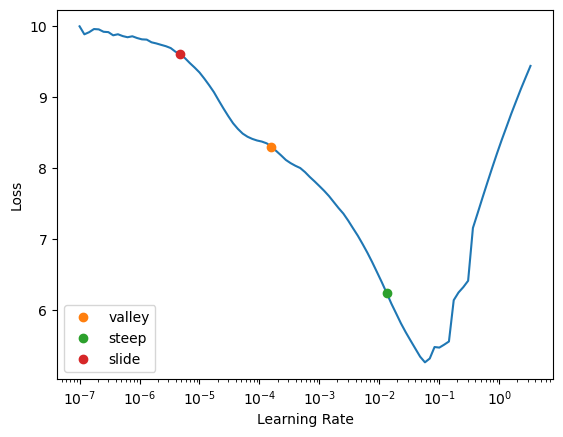

In [62]:
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

In [63]:
learn.fit_one_cycle(8, (lr.valley+lr.steep)/2, wd=0.2)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.072110,0.037764,0.713015,00:16
1,0.055028,0.030174,0.158617,00:16
2,0.015490,0.017952,0.135740,00:17
3,0.012453,0.014239,0.124102,00:17
4,0.010557,0.014589,0.117090,00:17
5,0.009265,0.013521,0.116512,00:16
6,0.007848,0.012601,0.113618,00:16
7,0.006672,0.012768,0.112509,00:17


# Evaluation

We load our test data into our learner and compute predictions on the test set:

In [64]:
dl = learn.dls.test_dl(test_df)

In [65]:
test_df.head()

,index,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,trend,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,1,4,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,c,a,1270.0,9,2008,0,1,1900,NaN,2015-09-20 - 2015-09-26,69,16,14,13,16,14,12,100,95,88,1013,1004,999,31.0,12.0,7.0,29,14,NaN,7.11,6.0,Rain,191,Hessen,2008-09-15,2558,24,1900-01-01,0,0,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,1,2,3,4,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015-09-20 - 2015-09-26,68,17,14,12,14,12,11,100,78,58,1010,1000,993,26.0,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen,2006-12-15,3198,24,2011-04-04,1627,25,37,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
2,2,3,7,4,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,24000.0,4,2013,0,1,1900,NaN,2015-09-20 - 2015-09-26,59,18,16,13,16,13,11,96,73,61,1003,998,994,26.0,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein,2013-04-15,885,24,1900-01-01,0,0,20,0,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
3,3,4,8,4,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,a,7520.0,10,2014,0,1,1900,NaN,2015-09-20 - 2015-09-26,59,18,16,13,16,13,11,96,73,61,1003,998,994,26.0,10.0,2.0,29,14,45.0,0.76,5.0,Rain,209,SchleswigHolstein,2014-10-15,337,11,1900-01-01,0,0,20,0,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
4,4,5,9,4,1.0,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,2030.0,8,2000,0,1,1900,NaN,2015-09-20 - 2015-09-26,68,17,14,12,14,12,11,100,78,58,1010,1000,993,26.0,12.0,8.0,37,26,53.0,3.05,6.0,Rain,187,NordrheinWestfalen,2000-08-15,5511,24,1900-01-01,0,0,37,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


In [66]:
dl.show_batch()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,week,trend,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,Promo_bw,Promo_fw,SchoolHoliday_bw,SchoolHoliday_fw,StateHoliday_bw,CompetitionDistance_na,Max_VisibilityKm_na,Mean_VisibilityKm_na,Min_VisibilitykM_na,Max_Gust_SpeedKm_h_na,CloudCover_na,CompetitionDistance,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,CompetitionDaysOpen,StateHoliday_fw
0,1,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,c,a,9,2008,0,1,1900,#na#,#na#,69,16,14,13,16,14,12,100,95,88,1013,1004,999,29,14,Rain,191,Hessen,2008-09-15,24,1900-01-01,0,0,13,0,105,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,True,False,1270.000166,31.0,12.0,7.0,47.0,7.110000e+00,6.0,2558.000014,-6.368568e-09
1,3,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,a,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",#na#,68,17,14,12,14,12,11,100,78,58,1010,1000,993,37,26,Rain,187,NordrheinWestfalen,2006-12-15,24,2011-04-04,1627,25,37,0,105,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,14129.999596,26.0,12.0,8.0,53.0,3.050000e+00,6.0,3197.999979,-6.368568e-09
2,7,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,4,2013,0,1,1900,#na#,#na#,59,18,16,13,16,13,11,96,73,61,1003,998,994,29,14,Rain,209,SchleswigHolstein,2013-04-15,24,1900-01-01,0,0,20,0,115,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,23999.999715,26.0,10.0,2.0,45.0,7.600000e-01,5.0,885.000002,-6.368568e-09
3,8,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,a,10,2014,0,1,1900,#na#,#na#,59,18,16,13,16,13,11,96,73,61,1003,998,994,29,14,Rain,209,SchleswigHolstein,2014-10-15,11,1900-01-01,0,0,20,0,115,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,7519.999954,26.0,10.0,2.0,45.0,7.600000e-01,5.0,336.999991,-6.368568e-09
4,9,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,8,2000,0,1,1900,#na#,#na#,68,17,14,12,14,12,11,100,78,58,1010,1000,993,37,26,Rain,187,NordrheinWestfalen,2000-08-15,24,1900-01-01,0,0,37,0,105,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,2029.999985,26.0,12.0,8.0,53.0,3.050000e+00,6.0,5510.999956,-6.368568e-09
5,10,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,a,9,2009,0,1,1900,#na#,#na#,70,18,16,13,15,13,12,94,75,57,1008,999,994,37,29,Rain,201,Niedersachsen,2009-09-15,24,1900-01-01,0,0,15,0,115,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,3159.999976,26.0,10.0,8.0,58.0,3.050000e+00,6.0,2192.999983,-6.368568e-09
6,11,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,11,2011,1,1,2012,"Jan,Apr,Jul,Oct",#na#,59,18,16,13,16,13,11,96,73,61,1003,998,994,29,14,Rain,209,SchleswigHolstein,2011-11-15,24,2012-01-02,1354,25,20,0,115,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,959.999815,26.0,10.0,2.0,45.0,7.600000e-01,5.0,1402.000001,-6.368568e-09
7,12,4,1,1,False,0,2015,9,38,17,3,260,False,False,False,False,False,False,a,c,1,1900,1,13,2010,"Jan,Apr,Jul,Oct",#na#,59,18,16,13,16,13,11,96,73,61,1003,998,994,29,14,Rain,209,SchleswigHolstein,1900-01-15,0,2010-03-29,1998,25,20,0,115,0,0,0,4.0,1.0,0.0,0.0,0.0,False,False,False,False,False,False,1069.999834,26.0,10.0,2.0,45.0,7.600000e-01,5.0,0.000011,-6.368568e-09
8,13,4,1,1,F

In [67]:
test_preds = learn.get_preds(dl=dl)

In [68]:
test_preds[:3]

(tensor([[ 8.3748],
         [ 8.8610],
         [ 9.0869],
         ...,
         [ 8.6602],
         [10.0106],
         [ 8.8364]]),
 None)

We've taken the log of the predictions, so we'll need to take the exponential of the predictions to get the predictions in the original scale.

In [69]:
test_preds = np.exp(test_preds[0].numpy().T[0])

In [70]:
test_preds[:3]

array([4336.2925, 7051.424 , 8838.732 ], dtype=float32)

In [71]:
# Insert into the test_df dataframe
test_df['Sales'] = test_preds

## Submit to Kaggle

We create a CSV file that can be used to submit our predictions to the [Kaggle Competition](https://www.kaggle.com/c/rossmann-store-sales/overview).

In [72]:
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

In [73]:
test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)

# Notes

The third-place finisher of the Kaggle competition used fewer features than we did. Here is their list of features. Feel free to repeat the above process using these, and see what results you get when submitting to Kaggle.

In [74]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']
   
dep_var = 'Sales'

> **Note:** Can use _pretrained_ embeddings, both as inputs to neural networks and as inputs of "classical" machine learning models. This is a powerful technique, and it's used in many real-world applications. See fastai Chapter9 for more. 